In [1]:
import pandas as pd
from visualization import *

In [2]:
dataset = "WorkersCompensation"
subset_col = "Gender"

In [3]:
results_df = pd.read_csv(f"results/{dataset}/{subset_col}.csv")

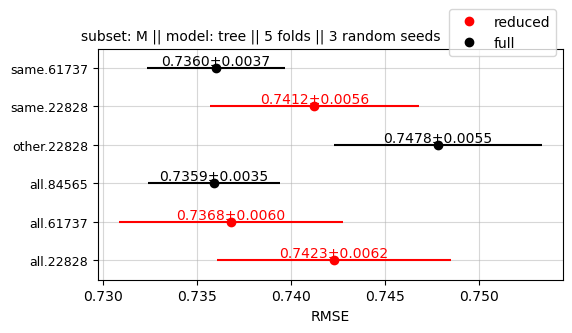

In [4]:
soak_plot_one_model(results_df, "M", "tree", "rmse", (6, 3))

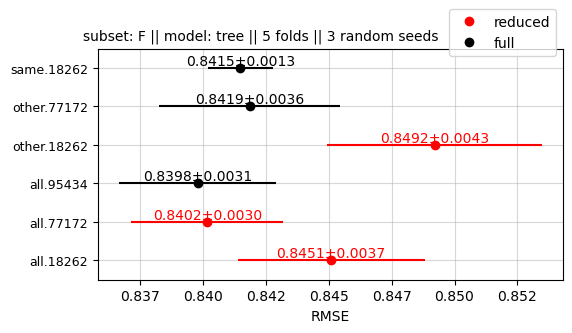

In [5]:
soak_plot_one_model(results_df, "F", "tree", "rmse", (6, 3))

{'F': <Figure size 1600x500 with 12 Axes>,
 'M': <Figure size 1600x500 with 12 Axes>}

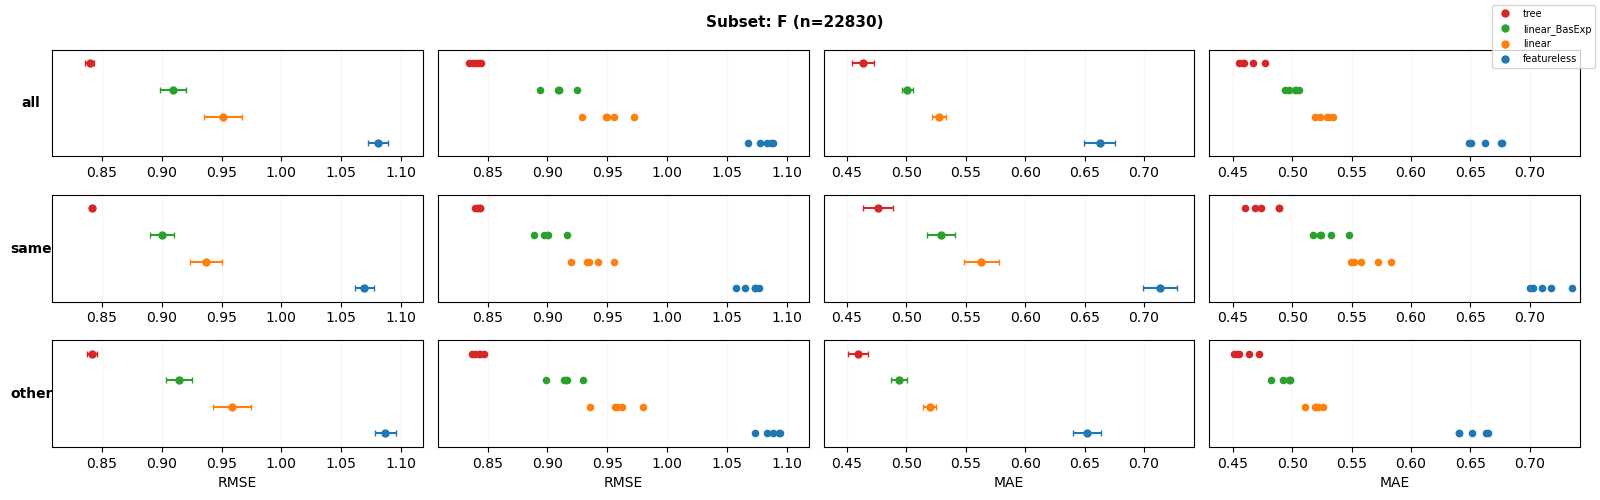

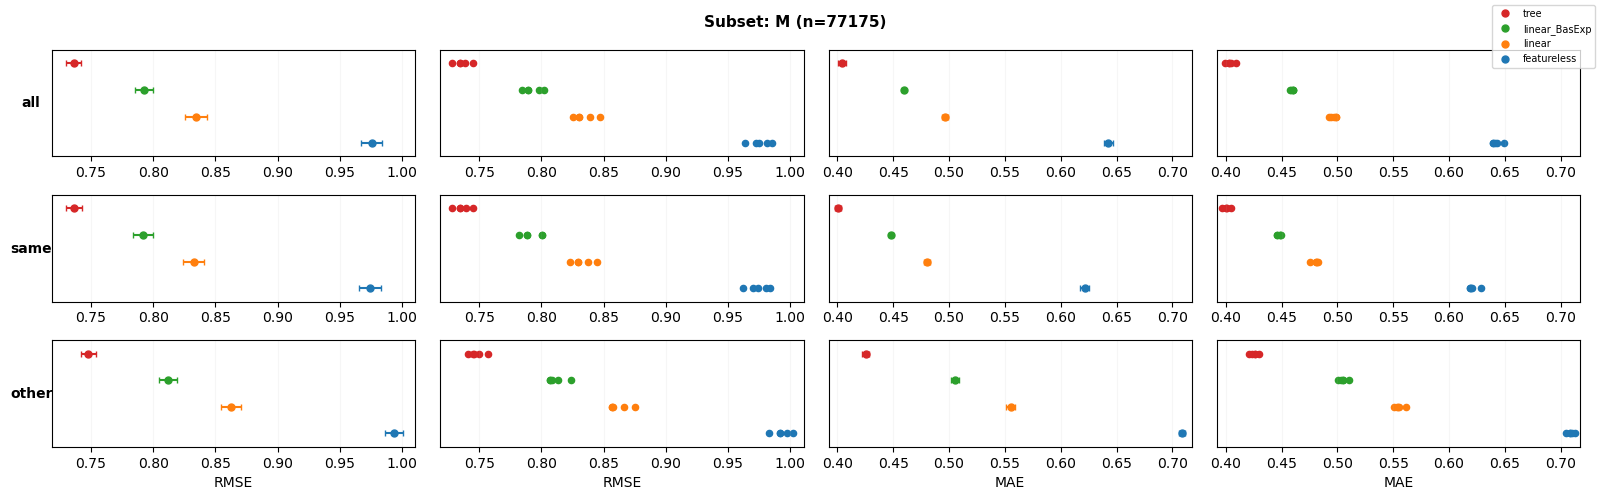

In [6]:
soak_plot_multiple_models(results_df)